In [1]:
import skimage.util
import skimage.io
from skimage.filters import threshold_otsu
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

### Loading Cropped tif image and setting channel id's
Image is the cropped part for the figure, full image is hosted on a seperate server or can be made available on request

In [2]:
img = skimage.io.imread('NJS127-A3-Crop.tif')

In [3]:
#Channel order of NJS127 Well A3
#0: Human-HEK GFP channel, (FITC) 
#1: Mouse barcode, B2-Cy3, (TRITC) 
#2: Human-HEK barcode, B1, (Cy5)
#3: Human-HEK GFP channel, (FITC)  (postdisplace)
#4: Mouse barcode, B2-Cy3, (TRITC) (postdisplace)
#5: Human-HEK barcode, B1, (Cy5)   (postdisplace)
#6: TFAM target (Human specific) CY5
#7: Lamin-B target TRITC
#8: Alpha-tubulin target FITC
#9: DAPI

#Pixel Scaling: 0.6556 pixels / micrometer

cID = ['GFP', 'MouseBC', 'HumanBC', 'Displace-GFP', 'Displace-Mouse', 'Displace-Human', 'TFAM-human', 'Lamin-B', 'Alpha-tubulin', 'DAPI']

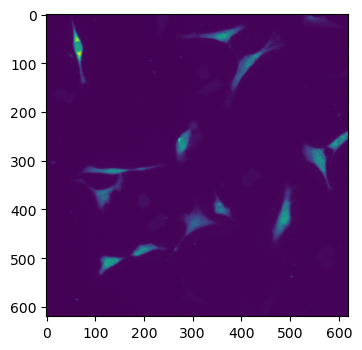

In [4]:
#Check the Mouse barcode channel
plt.imshow(img[1])

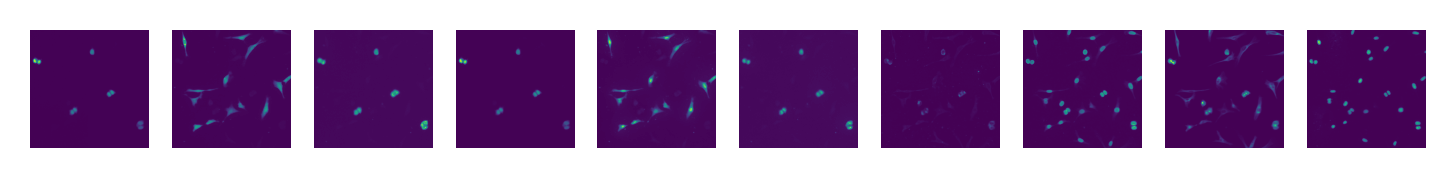

In [5]:
#quick overview of all channels
fig, axs = plt.subplots(1,10)
fig.dpi=300
for idx,_ in enumerate(cID):
    axs[idx].imshow(img[idx])
    axs[idx].set_axis_off()

In [6]:
#Normalize the display range of the images from 0 to 1, such that 1 is the 95th percentile of foreground pixels. 0 is unchanged.
#Do not perform the same operation on the displacement channels, use their initial channels as reference points.
def normalizeRange(arr):
    thresh = threshold_otsu(arr)
    pxforeground = arr[arr>thresh]
    #print(thresh)
    maxpx = np.percentile(pxforeground, 95)
    
    imgnorm = np.copy(arr)
    imgnorm = imgnorm / (np.percentile(pxforeground, 95))
    
    return imgnorm, maxpx

In [7]:
#Use a screenblend algorithm to blend multiple channels. This is equivalent to the photoshop "screenblend" function
def screenBlend(arr1, arr2):
    blend = 1 - (1-arr1)*(1-arr2)
    return blend

In [8]:
#Normalize the display ranges of all fluorescent channels
imgnorm = np.zeros((10,620,620))
pxmax = []
for idx, ch in enumerate(cID):

    imgnorm[idx], px = normalizeRange(img[idx])
    pxmax.append(px)

#check max pixel set for each channel
pxmax

[20342.0,
 9592.699999999999,
 6301.65,
 20236.5,
 8332.0,
 4352.0,
 18724.55,
 22932.74999999999,
 36232.0,
 21343.8]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


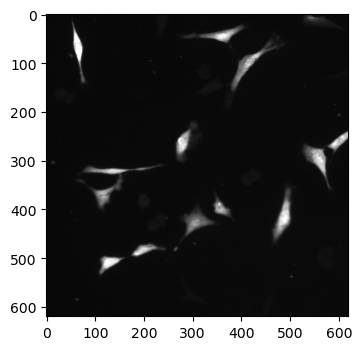

In [9]:
### Convert entire stack to a color image###
#selecting Ch2 should just be something like imgcolor[1]
imgcolor = skimage.color.gray2rgb(imgnorm)

#Mouse BC channel
plt.imshow(imgcolor[1])

### Set channel colors

### Channel order of NJS127 Well A3 (Scanned channel) (suggested colors)
0: Human-HEK GFP channel, (FITC) (Green)  
1: Mouse barcode, B2-Cy3, (TRITC) (Cyan)  
2: Human-HEK barcode, B1, (Cy5) (Magenta)  
3: Human-HEK GFP channel, (FITC)  (postdisplace) -Not used  
4: Mouse barcode, B2-Cy3, (TRITC) (postdisplace) -Not used  
5: Human-HEK barcode, B1, (Cy5)   (postdisplace) -Not used  
6: TFAM target (Human specific) CY5 (Red)  
7: Lamin-B target TRITC (yellow)  
8: Alpha-tubulin target FITC (Cyan, dont overlay with barcode images)  
9: DAPI (Blue)  

In [10]:
#Color dictionary of channels that will be multiplied by the img
#Ex: green should have the "R" and "B" channel set to 0 so channels 0, and 2 should be 0.
#add more color schemes here if you want more options
COLOR_DICT={"green"      :[0,1,0],
            "cyan"       :[0,1,1],
            "magenta"    :[1,0,1],
            "red"        :[1,0,0],
            "yellow"     :[1,1,0],
            "blue"       :[0,0,1],
            "dark orange":[1,0.55,0],
            "violet"     :[0.933, 0.510, 0.933]}

In [11]:
def setColor(img, **kwargs):
    ch = COLOR_DICT.get(
        kwargs.get("color")
    )
    
    newimg = img*ch
    return newimg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


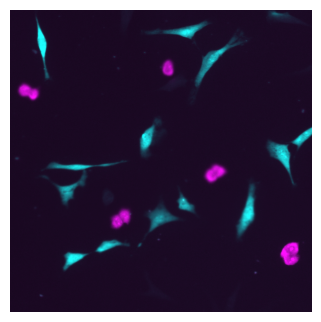

In [12]:
#Blend the mouse and human barcode channels
imgcolor[1] = setColor(imgcolor[1], color="cyan")
imgcolor[2] = setColor(imgcolor[2], color="magenta")
imgblend = screenBlend(imgcolor[1], imgcolor[2])

plt.imshow(imgblend, vmax=1)
plt.axis("off")
#plt.colorbar()
plt.savefig('NJS127-A3-Barcoded.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)
#skimage.io.imsave('NJS127-A3-Barcoded.tif', imgblend)

In [13]:
imgcolor = skimage.color.gray2rgb(imgnorm)
#Set colors for GFP and antibody channgels
imgcolor[0] = setColor(imgcolor[0],color = "green")
imgcolor[6] = setColor(imgcolor[6],color = "red")
imgcolor[7] = setColor(imgcolor[7],color = "yellow")
imgcolor[8] = setColor(imgcolor[8],color = "violet")
imgcolor[9] = setColor(imgcolor[9],color = "blue")

In [14]:
#Channel overlays can look bad if not blended right, pick and choose which channels an which colors you want to blend

#pick different channels here
blend = [7,8]

for idx,ch in enumerate(blend):
    if idx==0:
        img = np.copy(imgcolor[blend[0]])
        imgblend = screenBlend(img, imgcolor[blend[idx+1]])
    elif idx==1:
        continue
    else:
        imgblend = screenBlend(imgblend, imgcolor[ch])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


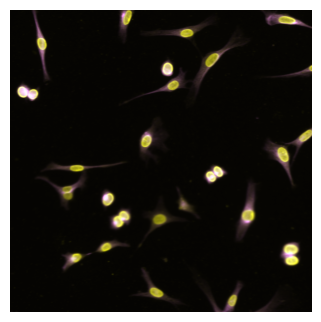

In [15]:
plt.imshow(imgblend, vmax=1)
plt.axis("off")
#plt.colorbar()
plt.savefig('NJS127-A3-antibodystain-Overlay.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


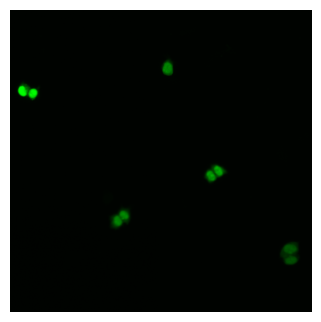

In [16]:
#Save individual Antibody channels and GFP channel
plt.imshow(imgcolor[0], vmax=1)
plt.axis("off")
plt.savefig('NJS127-A3-GFP.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


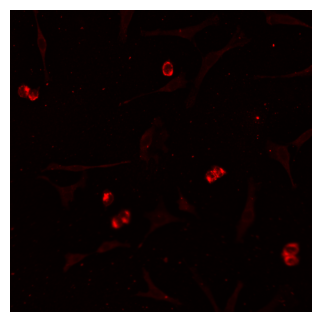

In [17]:
plt.imshow(imgcolor[6], vmax=1)
plt.axis("off")
plt.savefig('NJS127-A3-TFAM.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


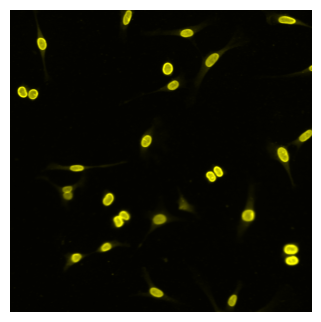

In [18]:
plt.imshow(imgcolor[7], vmax=1)
plt.axis("off")
plt.savefig('NJS127-A3-Lamin.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


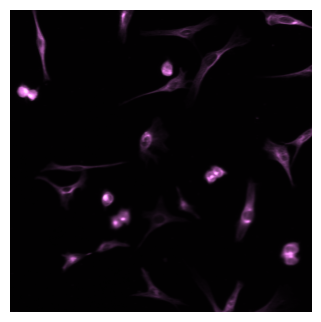

In [19]:
plt.imshow(imgcolor[8], vmax=1)
plt.axis("off")
plt.savefig('NJS127-A3-Tubulin.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


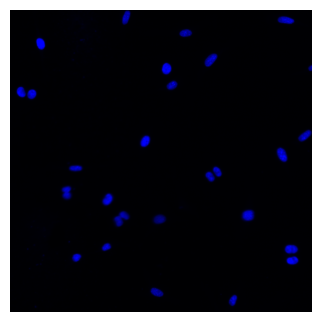

In [20]:
plt.imshow(imgcolor[9], vmax=1)
plt.axis("off")
plt.savefig('NJS127-A3-Dapi.png', dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)

In [21]:
#Note on scale bar scaling
#We've cropped out a 620x620 region from the tif stack. Pixel scaling is 0.6556 px/micron at this size.
#When importing images into illustrator, make note of the new size that it imports at.

#### Smaller Crops of the antibody stains for individual displays
Set size to be 150 px in height so you can fit 4 next to big figure

In [22]:
imgcrop = imgcolor[:, 60:210, 250:500, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


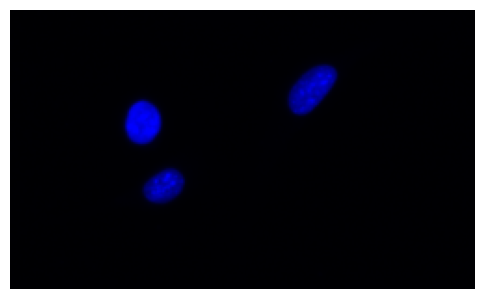

In [23]:
#Save last 4 channels
imgnames = ['NJS127-A3-TFAM-crop.png', 'NJS127-A3-Lamin-crop.png', 'NJS127-A3-Tubulin-crop.png', 'NJS127-A3-Dapi-crop.png']
for idx,img in enumerate(imgcrop[6:]):
    plt.imshow(img)
    plt.axis("off")
    plt.savefig(imgnames[idx], dpi=1000, bbox_inches='tight', transparent='True', pad_inches=0)